# Using `MLlib` from `pyspark` to Fit Machine Learning Models

Create a spark instance (I'm on Windows so I'll need a few more things as well).

In [2]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Now read in a data set using regular `pandas` and convert it to a `spark` SQL style data frame.

In [4]:
bike_data = pd.read_csv("bikeDetails.csv")
bike_data.head()

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN


Convert to a spark SQL data frame.

In [5]:
bike = spark.createDataFrame(bike_data)
bike.show(5)

+--------------------+-------------+----+-----------+---------+---------+-----------------+
|                name|selling_price|year|seller_type|    owner|km_driven|ex_showroom_price|
+--------------------+-------------+----+-----------+---------+---------+-----------------+
|Royal Enfield Cla...|       175000|2019| Individual|1st owner|      350|              NaN|
|           Honda Dio|        45000|2017| Individual|1st owner|     5650|              NaN|
|Royal Enfield Cla...|       150000|2018| Individual|1st owner|    12000|         148114.0|
|Yamaha Fazer FI V...|        65000|2015| Individual|1st owner|    23000|          89643.0|
|Yamaha SZ [2013-2...|        20000|2011| Individual|2nd owner|    21000|              NaN|
+--------------------+-------------+----+-----------+---------+---------+-----------------+
only showing top 5 rows



We'll fit a linear regression model using log selling price as our response and log km driven and year as our predictors.  This means we need to create some new columns and drop a bunch of others. 
- We also **need to rename the response** as 'label'.  
- These first steps are done using the `SQLTransformer()` function from `pyspark.ml.feature`.  
- This will allow us to place these transformations into a `pipeline` (which we'll do in a minute).  

Note: Since the transformations we are doing are simple, we could just do them first (say with `pyspark.sql.functions`).

In [6]:
from pyspark.ml.feature import SQLTransformer

In [7]:
sqlTrans = SQLTransformer(
    statement = "SELECT year, log(km_driven) as log_km_driven, log(selling_price) as label FROM __THIS__"
)

On any of the transformation methods we do, there is a `.transform()` method that is used to actually feed it data.  Here, we feed it the spark SQL data frame `bike`.

In [8]:
sqlTrans.transform(bike).show(5)

+----+------------------+------------------+
|year|     log_km_driven|             label|
+----+------------------+------------------+
|2019| 5.857933154483459|12.072541252905651|
|2017| 8.639410824140487|10.714417768752456|
|2018| 9.392661928770137|11.918390573078392|
|2015|10.043249494911286|11.082142548877775|
|2011|  9.95227771670556| 9.903487552536127|
+----+------------------+------------------+
only showing top 5 rows



We also **need to put the predictors into a single column** called 'features'.  
Placing multiple columns into one can be done via `VectorAssembler()` from `pyspark.ml.feature`.

In [12]:
from pyspark.ml.feature import VectorAssembler

In [13]:
assembler = VectorAssembler(inputCols = ["year", "log_km_driven"], outputCol = "features", handleInvalid = 'keep')

Notice that we are passing what would be the result columns from the previous SQL transform we did.  The `VectorAssembler()` also has a `.transform()` method.  Let's see how these would be used together to produce a new data set.

In [14]:
assembler.transform(
    sqlTrans.transform(bike)
).select("label", "features").show(5)

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
|12.072541252905651|[2019.0,5.8579331...|
|10.714417768752456|[2017.0,8.6394108...|
|11.918390573078392|[2018.0,9.3926619...|
|11.082142548877775|[2015.0,10.043249...|
| 9.903487552536127|[2011.0,9.9522777...|
+------------------+--------------------+
only showing top 5 rows



Awesome!  Our data is now transformed to have the new variables we want and the data is in the format needed to fit model using `MLlib`.  Specifically:
- A column named `label` that is the response variable
- A column named `features` that is a column containing all the predictor values together

Next step, we'll fit a basic multiple linear regression model using the `LinearRegression()` function from `pyspark.ml.regression`.  This function does regularized regression (Elastic net, which includes LASSO and Ridge Regression as special cases) so there are a few set up parameters we can modify to just get the usual MLR fit.

In [15]:
from pyspark.ml.regression import LinearRegression

In [16]:
lr = LinearRegression(regParam = 0, elasticNetParam = 0)

Now we can use the `.fit()` method on the transformed data we made above.

In [17]:
lrModel = lr.fit(
    assembler.transform(
        sqlTrans.transform(bike)
    ).select("label", "features")
)

We can inspect the model fit using attributes of our `lrModel` object.

In [18]:
print("Intercept: %s" % str(lrModel.intercept), "Coefficients: %s" % str(lrModel.coefficients))

Intercept: -148.79329108280237 Coefficients: [0.08033659998872915,-0.22686128977706782]


Let's inspect the training set RMSE and other model fit metrics.

In [19]:
trainingSummary = lrModel.summary
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

C:\Users\mnikiforov\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+
|           residuals|
+--------------------+
|-0.00482477068216...|
| -0.5712654432333988|
|  0.7232542782261024|
| 0.27560918835935944|
| -0.6023373829644285|
+--------------------+
only showing top 5 rows

RMSE: 0.510952
r2: 0.483049


Of course we will often want to do predictions as well.  This is easy to do!  The model itself actually becomes a transformer once it is fit!  We just use the `.transform()` method and pass it data similar in format to that on which the model was trained.  Here we'll just look at the prediction from the data used to fit the model.

In [20]:
preds = lrModel.transform(
    assembler.transform(
        sqlTrans.transform(bike)
    ).select("label", "features")
)

In [21]:
preds.show(5)

+------------------+--------------------+------------------+
|             label|            features|        prediction|
+------------------+--------------------+------------------+
|12.072541252905651|[2019.0,5.8579331...|12.077366023587814|
|10.714417768752456|[2017.0,8.6394108...|11.285683211985855|
|11.918390573078392|[2018.0,9.3926619...| 11.19513629485229|
|11.082142548877775|[2015.0,10.043249...|10.806533360518415|
| 9.903487552536127|[2011.0,9.9522777...|10.505824935500556|
+------------------+--------------------+------------------+
only showing top 5 rows



Cool!  We've fit an MLR model using the `pyspark` `MLlib` library!

# Using Cross-Validation to Select Our Model

Of course we know that what we care about is the quality of the prediction our model makes on **data it wasn't trained on**.  Generally, this means we need to either 
- split our data into a training and test (sometimes called validation) set
- use cross-validation

And of course, we've talked about the need for both when selecting from many types of models.

Let's focus on doing k-fold CV using `pyspark`.  We need to set up our grid of tuning parameters (if applicable) and then run our CV algorithm.  This can be done using the `ParamGridBuilder()` and `CrossValidator()` functions from `pyspark.ml.tuning`, respectively.

In [22]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

The only tuning parameter we'll worry about is fitting the intercept.  We can look at how well the model does when we fit an intercept vs when we don't.  We use `ParamGridBuilder()` and `.addGrid()` to specify the tuning parameter values.  Then finally we use the `.build()` method to instruct it to build the grid.

In [23]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()

Next up, we can use the `CrossValidator()` function to run k-fold CV over the grid of tuning parameters we just set up.  

We need to tell `pyspark` what loss function to use when evaluating.  This is done via the `RegressionEvaluator()` function from `pyspark.ml.evaluation`.  To override the default metric used we can specify it explicitly using the `metricName=` argument when calling the function.  `rmse` is the default here.

In [24]:
from pyspark.ml.evaluation import RegressionEvaluator

In [25]:
lr = LinearRegression()
crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid,
                          evaluator = RegressionEvaluator(metricName='rmse'),
                          numFolds=5)

We've now set up the `crossval` object.  Just like with `sklearn` we now use the `.fit()` method to actually fit the models.

In [26]:
cvModel = crossval.fit(
    assembler.transform(
        sqlTrans.transform(bike)
    ).select("label", "features")
)

By default, the only model returned is the **best** model as measured by our Loss function.  If you want your submodels back, pass `collectSubModels = True`.  

To determine which model was returned we can look at the `.avgMetrics` attribute along with the `paramGrid` object we used to fit the models.

In [27]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.5134996830715035,
  {Param(parent='LinearRegression_c4ff654767f2', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_c4ff654767f2', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LinearRegression_c4ff654767f2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.5134996830715035,
  {Param(parent='LinearRegression_c4ff654767f2', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_c4ff654767f2', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LinearRegression_c4ff654767f2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

We can see the best model's parameter estimates as well.

In [28]:
print(cvModel.bestModel._java_obj.intercept(), cvModel.bestModel._java_obj.coefficients())

-148.79329108280237 [0.08033659998872915,-0.22686128977706782]


As with the single linear model fit we did above, this new object, `cvModel`, is now a transformation as well.  This allows us to get prediction using the best fit model.  If we had a test set we could use it to get the test set prediction easily.  As we didn't split into a test set, let's just see how to use it to predict on the training data (i.e. return the fitted values for the model).

In [29]:
preds = cvModel.transform(
    assembler.transform(
        sqlTrans.transform(bike)
    ).select("label", "features")
)

In [30]:
preds.show(5)

+------------------+--------------------+------------------+
|             label|            features|        prediction|
+------------------+--------------------+------------------+
|12.072541252905651|[2019.0,5.8579331...|12.077366023587814|
|10.714417768752456|[2017.0,8.6394108...|11.285683211985855|
|11.918390573078392|[2018.0,9.3926619...| 11.19513629485229|
|11.082142548877775|[2015.0,10.043249...|10.806533360518415|
| 9.903487552536127|[2011.0,9.9522777...|10.505824935500556|
+------------------+--------------------+------------------+
only showing top 5 rows



We can find the training RMSE by passing these predictions to the `RegressionEvaluator().evaluate()` method.

In [31]:
RegressionEvaluator().evaluate(cvModel.transform(
    assembler.transform(
        sqlTrans.transform(bike)
    ).select("label", "features")
))

0.5109515293369582

# Pipelines and the Training/Test Split

Of course we often want to have a training and test set so we can do all of our model fitting and tuning on the training set and then see how different model types compare on the test set.  We should always split our data into training and test sets first, before doing transformations.  Reason being:
- If we do transformations on the training set, we want to use the exact same transformations on the test set
- For instance, if we center some predictors (subtract the mean) in our training set, we want to subtract the mean of the **training** set to standardize the test set values prior to doing test set predictions!
- By splitting the data first, we can make sure we aren't using any test data (and the knowledge that comes with it) when training our models

By setting up a **pipeline** in `MLlib` we can easily (haha, yeah right) create the sequence of transformations/model fits and apply those same transformations on our test set!

Let's start with the training/test split.  This can be done using the `.randomSplit()` method on a spark SQL style data frame.

In [32]:
train, test = bike.randomSplit([0.8,0.2], seed = 1)
print(train.count(), test.count())

855 206


Now that we've split our data we can **set up** the transformations to do.  Just like with other spark stuff, things are set up as a DAG and done only at run time.  
We created the transformation plans previously so we'll just pull them down here for clarity.

In [33]:
sqlTrans = SQLTransformer(
    statement = "SELECT year, log(km_driven) as log_km_driven, log(selling_price) as label FROM __THIS__"
)

In [34]:
assembler = VectorAssembler(inputCols = ["year", "log_km_driven"], outputCol = "features", handleInvalid = 'keep')

We are then ready to create our pipeline that includes these transformations and the model that we want to fit.  First, more on what a pipeline is/contains.  From the guide:
> A Pipeline is specified as a sequence of stages, and each stage is either a Transformer (like above) or an Estimator (like a model).

> These stages are run in order, and the input DataFrame is transformed as it passes through each stage. For Transformer stages, the `.transform()` method is called on the DataFrame. 

> For Estimator stages, the `.fit()` method is called to produce a Transformer (which becomes part of the PipelineModel, or fitted Pipeline), and that Transformer’s `.transform()` method is called on the DataFrame.

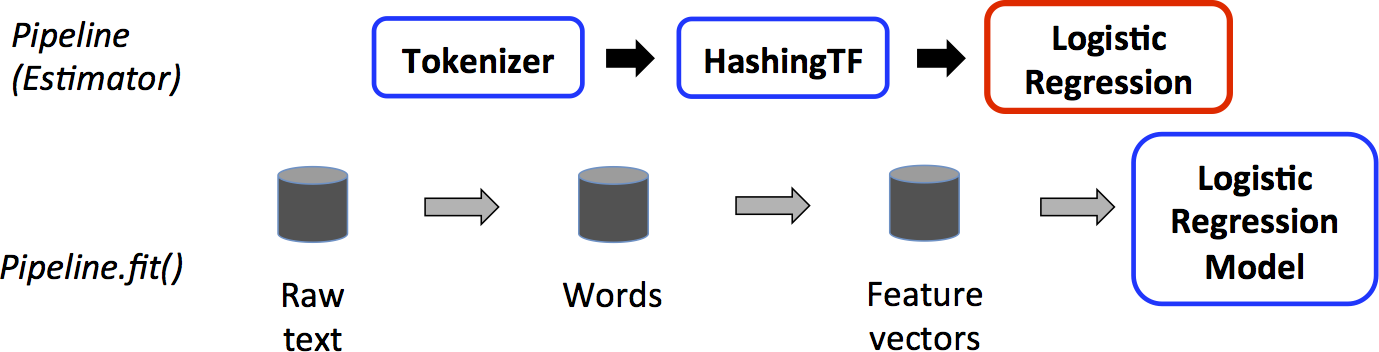

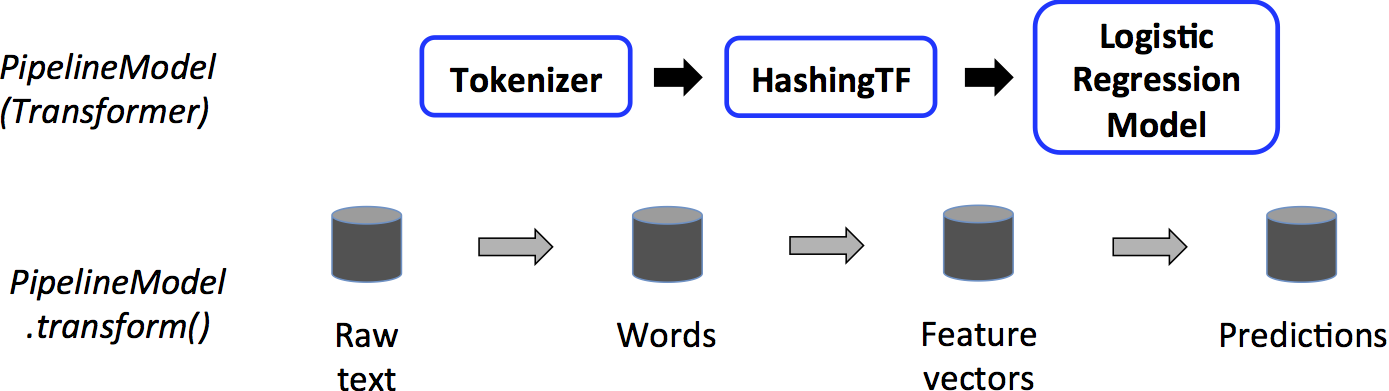

We use the `Pipeline()` function from the `pyspark.ml` module to set up our sequence of transformations/estimators.

In [35]:
from pyspark.ml import Pipeline

In [36]:
pipeline = Pipeline(stages = [sqlTrans, assembler, lr])

Our DAG is now set up and we can use this pipeline within our CV calculation (or basic model fitting).  What's nice is that since it contains all the information about the transformations done, we can easily apply this to a test set and not have to worry about how to do the transformations/prepping of the data on that set.  

Let's set up our cross-validation again just for clarity.  Instead of using the model type as the `estimator` we'll pass the pipeline we've set up.

In [37]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = RegressionEvaluator(),
                          numFolds=5)

With everything set up, we can now fit our models!

In [38]:
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

Check which model is chosen as the best:

In [39]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.5807022230986376,
  {Param(parent='LinearRegression_2622fbbbfa30', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_2622fbbbfa30', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LinearRegression_2622fbbbfa30', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.5116588241064207,
  {Param(parent='LinearRegression_2622fbbbfa30', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_2622fbbbfa30', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LinearRegression_2622fbbbfa30', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

Use that best model to get test error on the test set.

In [40]:
cvModel.transform(test).show(5)

+----+------------------+------------------+--------------------+------------------+
|year|     log_km_driven|             label|            features|        prediction|
+----+------------------+------------------+--------------------+------------------+
|2012| 10.46310334047155|10.126591103050316|[2012.0,10.463103...|10.460994905142485|
|2013|10.678214720088496|10.596634733096073|[2013.0,10.678214...|10.492616813977548|
|2015|10.033199159057785|10.645424897265505|[2015.0,10.033199...|10.806476529414994|
|2011|10.043249494911286|10.645424897265505|[2011.0,10.043249...|10.477094246514469|
|2015|  9.67130325656977|11.082142548877775|[2015.0,9.6713032...|10.890827007621596|
+----+------------------+------------------+--------------------+------------------+
only showing top 5 rows



In [41]:
test_error = RegressionEvaluator().evaluate(cvModel.transform(test))
print(test_error)

0.5231179508534636


Fantastic!  We can now set up a pipeline and use CV to fit our model.  Then we can take the best model and find test set predictions!  

Remember, once we have our final model we fit that model on the entire data set.  Then we use it for future predictions and what-not.